## **Question 1**

# **Part I**

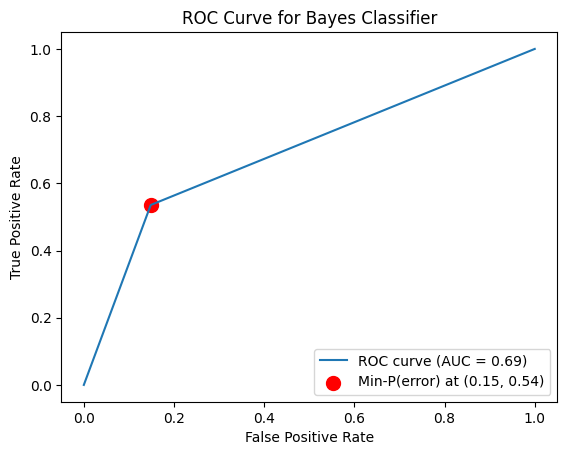

Minimum Probability of Error: 0.6128


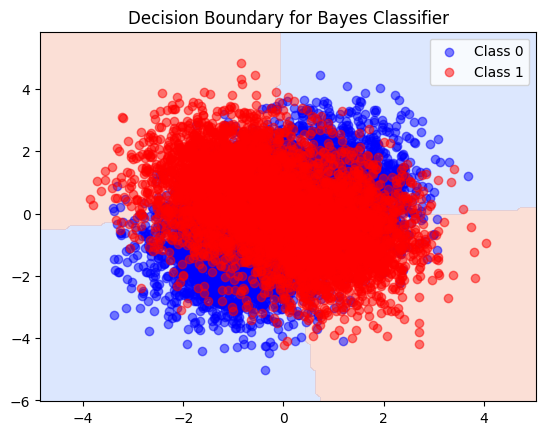

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.metrics import roc_curve, roc_auc_score

# Mean vectors
m01 = np.array([-0.9, -1.1])
m02 = np.array([0.8, 0.75])
m11 = np.array([-1.1, 0.9])
m12 = np.array([0.9, -0.75])

# Covariance matrices
C01 = C02 = C11 = C12 = np.array([[0.75, 0], [0, 1.25]])

# Class priors
P_L0 = 0.6
P_L1 = 0.4

# Function to sample from the mixture of Gaussians
def generate_samples(n_samples, mean1, mean2, cov1, cov2):
    n_half = n_samples // 2
    samples1 = np.random.multivariate_normal(mean1, cov1, n_half)
    samples2 = np.random.multivariate_normal(mean2, cov2, n_half)
    return np.vstack((samples1, samples2))

# Generate datasets with new sizes
D_train_50 = np.vstack([
    generate_samples(25, m01, m02, C01, C02),
    generate_samples(25, m11, m12, C11, C12)
])

D_train_500 = np.vstack([
    generate_samples(250, m01, m02, C01, C02),
    generate_samples(250, m11, m12, C11, C12)
])

D_train_5000 = np.vstack([
    generate_samples(2500, m01, m02, C01, C02),
    generate_samples(2500, m11, m12, C11, C12)
])

D_validate_10K = np.vstack([
    generate_samples(5000, m01, m02, C01, C02),
    generate_samples(5000, m11, m12, C11, C12)
])

# True labels for validation set (first 5000 are L=0, next 5000 are L=1)
y_true = np.array([0] * 5000 + [1] * 5000)

# Gaussian likelihood function
def gaussian_likelihood(x, mean, cov):
    return multivariate_normal.pdf(x, mean=mean, cov=cov)

def bayes_classifier(x):
    # Likelihoods for L=0 and L=1 (using mixture of two Gaussians for each)
    likelihood_L0 = (0.5 * gaussian_likelihood(x, m01, C01) +
                     0.5 * gaussian_likelihood(x, m02, C02)) * P_L0
    likelihood_L1 = (0.5 * gaussian_likelihood(x, m11, C11) +
                     0.5 * gaussian_likelihood(x, m12, C12)) * P_L1

    # Compare posterior probabilities and classify
    return 0 if likelihood_L0 > likelihood_L1 else 1

# Classify all samples in the validation dataset
y_pred = np.array([bayes_classifier(x) for x in D_validate_10K])

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred)

min_error_index = np.argmax(tpr - fpr)
min_error_fpr = fpr[min_error_index]
min_error_tpr = tpr[min_error_index]
min_p_error = 1 - (tpr[min_error_index] - fpr[min_error_index])

# Plot the ROC curve with min-P(error) marker
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.scatter(min_error_fpr, min_error_tpr, color='red', marker='o', s=100,
            label=f'Min-P(error) at ({min_error_fpr:.2f}, {min_error_tpr:.2f})')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Bayes Classifier")
plt.legend(loc="lower right")
plt.show()

print(f"Minimum Probability of Error: {min_p_error:.4f}")

# Create a grid of points for decision boundary visualization
x_min, x_max = D_validate_10K[:, 0].min() - 1, D_validate_10K[:, 0].max() + 1
y_min, y_max = D_validate_10K[:, 1].min() - 1, D_validate_10K[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Classify each point on the grid
grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_predictions = np.array([bayes_classifier(p) for p in grid_points])
grid_predictions = grid_predictions.reshape(xx.shape)

# Plot the decision boundary and the dataset
plt.contourf(xx, yy, grid_predictions, alpha=0.3, levels=[-1, 0, 1], cmap='coolwarm')
plt.scatter(D_validate_10K[:5000, 0], D_validate_10K[:5000, 1], c='blue',
label="Class 0", alpha=0.5)
plt.scatter(D_validate_10K[5000:, 0], D_validate_10K[5000:, 1], c='red',
label="Class 1", alpha=0.5)
plt.title("Decision Boundary for Bayes Classifier")
plt.legend(loc="upper right")
plt.show()

# **Part II**

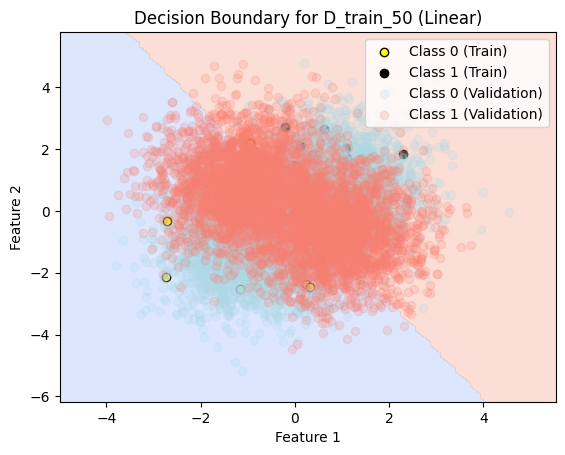

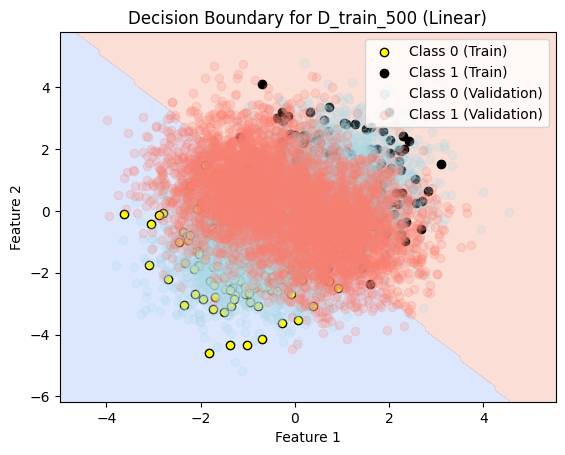

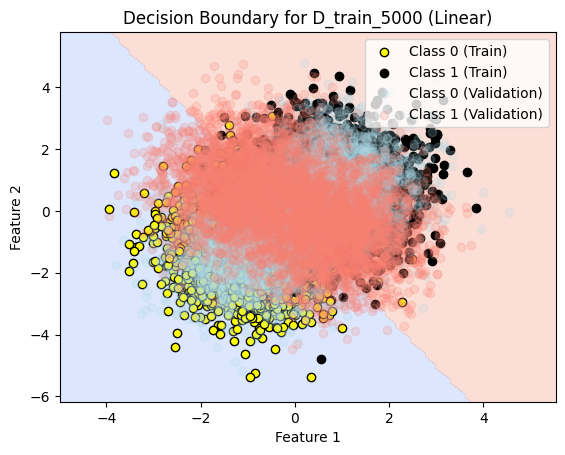

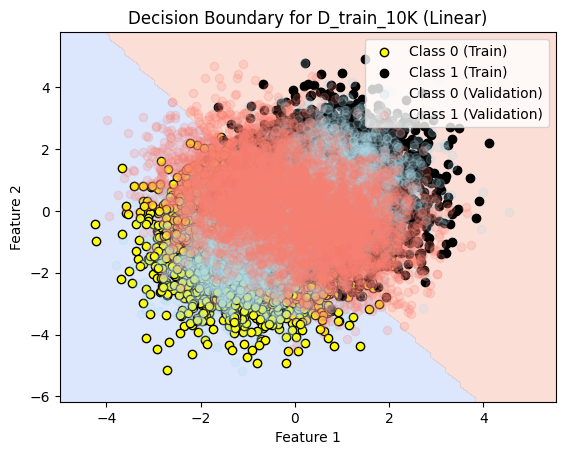

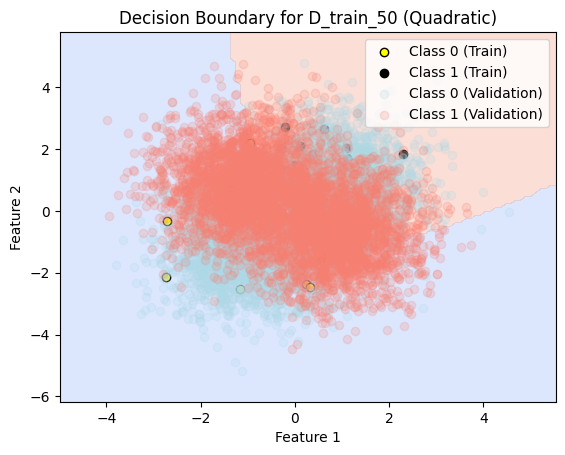

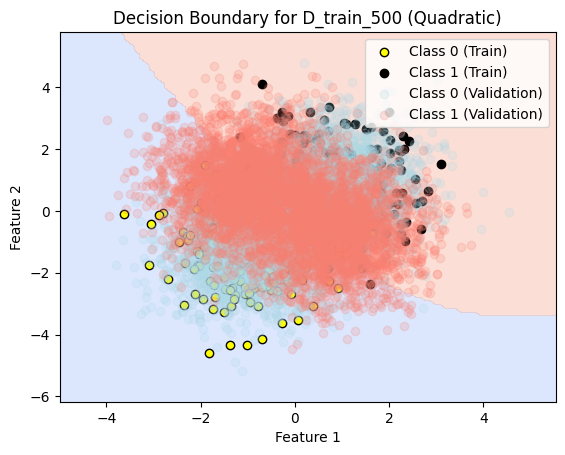

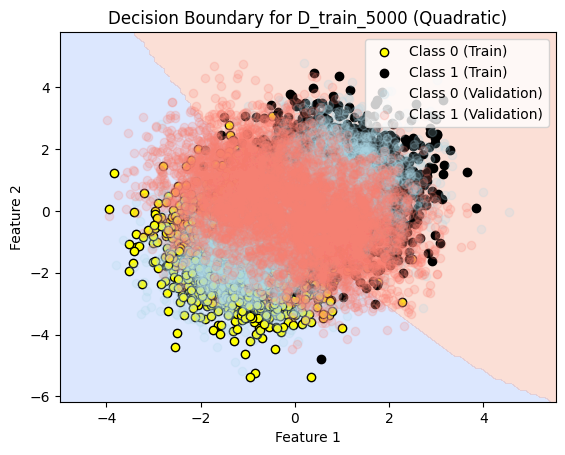

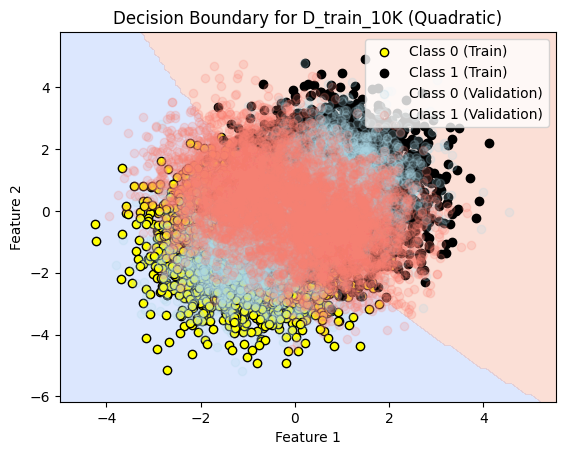

Error rate for logistic-linear model trained on D_train_50: 0.5047
Error rate for logistic-linear model trained on D_train_500: 0.4773
Error rate for logistic-linear model trained on D_train_5000: 0.4779
Error rate for logistic-linear model trained on D_train_10K: 0.4770
Error rate for logistic-quadratic model trained on D_train_50: 0.5526
Error rate for logistic-quadratic model trained on D_train_500: 0.4869
Error rate for logistic-quadratic model trained on D_train_5000: 0.4821
Error rate for logistic-quadratic model trained on D_train_10K: 0.4845


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import PolynomialFeatures

m01 = np.array([-0.9, -1.1])
m02 = np.array([0.8, 0.75])
m11 = np.array([-1.1, 0.9])
m12 = np.array([0.9, -0.75])

# Define covariance matrices
C01 = C02 = C11 = C12 = np.array([[0.75, 0], [0, 1.25]])

# Define class priors
P_L0 = 0.6
P_L1 = 0.4

# Define the generate_samples function
def generate_samples(n_samples, mean1, mean2, cov1, cov2):
    n_half = n_samples // 2
    samples1 = np.random.multivariate_normal(mean1, cov1, n_half)
    samples2 = np.random.multivariate_normal(mean2, cov2, n_half)
    return np.vstack((samples1, samples2))

# Example of generating labels for a dataset with 50% split between classes
def generate_labels(n_samples):
    return np.array([0] * (n_samples // 2) + [1] * (n_samples // 2))

# Generate training datasets with new sizes
D_train_50 = generate_samples(50, m01, m02, C01, C02)
y_train_50 = np.array([0] * 25 + [1] * 25)

D_train_500 = generate_samples(500, m01, m02, C01, C02)
y_train_500 = np.array([0] * 250 + [1] * 250)

D_train_5000 = generate_samples(5000, m01, m02, C01, C02)
y_train_5000 = np.array([0] * 2500 + [1] * 2500)

# Generate D_train_10K dataset
D_train_10K = generate_samples(10000, m01, m02, C01, C02)
y_train_10K = np.array([0] * 5000 + [1] * 5000)

# Generate the validation dataset with 10,000 samples (5,000 for each class)
D_validate_10K = np.vstack([
    generate_samples(5000, m01, m02, C01, C02),
    generate_samples(5000, m11, m12, C11, C12)
])

# True labels for the validation set (first 5000 are L=0, next 5000 are L=1)
y_true = np.array([0] * 5000 + [1] * 5000)

# Logistic-linear models
log_reg_50 = LogisticRegression()
log_reg_50.fit(D_train_50, y_train_50)

log_reg_500 = LogisticRegression()
log_reg_500.fit(D_train_500, y_train_500)

log_reg_5000 = LogisticRegression()
log_reg_5000.fit(D_train_5000, y_train_5000)

# Logistic-linear model trained on D_train_10K
log_reg_10K = LogisticRegression()
log_reg_10K.fit(D_train_10K, y_train_10K)

# Plot decision boundary for each logistic-linear classifier with enhanced visualization
def plot_decision_boundary(model, D_train, y_train, title):
    x_min, x_max = D_validate_10K[:, 0].min() - 1, D_validate_10K[:, 0].max() + 1
    y_min, y_max = D_validate_10K[:, 1].min() - 1, D_validate_10K[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3, levels=[-1, 0, 1], cmap='coolwarm')
    plt.scatter(D_train[y_train == 0][:, 0], D_train[y_train == 0][:, 1],
color='yellow', label="Class 0 (Train)", edgecolor='k')
    plt.scatter(D_train[y_train == 1][:, 0], D_train[y_train == 1][:, 1],
color='black', label="Class 1 (Train)", edgecolor='k')
    plt.scatter(D_validate_10K[:5000, 0], D_validate_10K[:5000, 1],
color='lightblue', alpha=0.2, label="Class 0 (Validation)")
    plt.scatter(D_validate_10K[5000:, 0], D_validate_10K[5000:, 1],
color='salmon', alpha=0.2, label="Class 1 (Validation)")
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend(loc="upper right")
    plt.show()

# Plot decision boundaries for each logistic-linear model
plot_decision_boundary(log_reg_50, D_train_50, y_train_50, "Decision Boundary for D_train_50 (Linear)")
plot_decision_boundary(log_reg_500, D_train_500, y_train_500, "Decision Boundary for D_train_500 (Linear)")
plot_decision_boundary(log_reg_5000, D_train_5000, y_train_5000, "Decision Boundary for D_train_5000 (Linear)")
plot_decision_boundary(log_reg_10K, D_train_10K, y_train_10K, "Decision Boundary for D_train_10K (Linear)")

# Polynomial transformation for quadratic classifiers
poly = PolynomialFeatures(degree=2, include_bias=False)
D_train_50_quadratic = poly.fit_transform(D_train_50)
D_train_500_quadratic = poly.fit_transform(D_train_500)
D_train_5000_quadratic = poly.fit_transform(D_train_5000)
D_train_10K_quadratic = poly.fit_transform(D_train_10K)
D_validate_10K_quadratic = poly.transform(D_validate_10K)

# Logistic-quadratic models
log_reg_50_quadratic = LogisticRegression()
log_reg_50_quadratic.fit(D_train_50_quadratic, y_train_50)

log_reg_500_quadratic = LogisticRegression()
log_reg_500_quadratic.fit(D_train_500_quadratic, y_train_500)

log_reg_5000_quadratic = LogisticRegression()
log_reg_5000_quadratic.fit(D_train_5000_quadratic, y_train_5000)

# Logistic-quadratic model trained on D_train_10K
log_reg_10K_quadratic = LogisticRegression()
log_reg_10K_quadratic.fit(D_train_10K_quadratic, y_train_10K)

def plot_decision_boundary_quadratic(model, D_train, y_train, title):
    x_min, x_max = D_validate_10K[:, 0].min() - 1, D_validate_10K[:, 0].max() + 1
    y_min, y_max = D_validate_10K[:, 1].min() - 1, D_validate_10K[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

    # Transform the grid points to include quadratic terms
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    grid_points_quadratic = poly.transform(grid_points)

    Z = model.predict(grid_points_quadratic)
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3, levels=[-1, 0, 1], cmap='coolwarm')
    plt.scatter(D_train[y_train == 0][:, 0], D_train[y_train == 0][:, 1],
color='yellow', label="Class 0 (Train)", edgecolor='k')
    plt.scatter(D_train[y_train == 1][:, 0], D_train[y_train == 1][:, 1],
color='black', label="Class 1 (Train)", edgecolor='k')
    plt.scatter(D_validate_10K[:5000, 0], D_validate_10K[:5000, 1],
color='lightblue', alpha=0.2, label="Class 0 (Validation)")
    plt.scatter(D_validate_10K[5000:, 0], D_validate_10K[5000:, 1],
color='salmon', alpha=0.2, label="Class 1 (Validation)")
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend(loc="upper right")
    plt.show()

# Plot decision boundaries for each logistic-quadratic model
plot_decision_boundary_quadratic(log_reg_50_quadratic, D_train_50, y_train_50,
"Decision Boundary for D_train_50 (Quadratic)")
plot_decision_boundary_quadratic(log_reg_500_quadratic, D_train_500,
y_train_500, "Decision Boundary for D_train_500 (Quadratic)")
plot_decision_boundary_quadratic(log_reg_5000_quadratic, D_train_5000,
y_train_5000, "Decision Boundary for D_train_5000 (Quadratic)")
plot_decision_boundary_quadratic(log_reg_10K_quadratic, D_train_10K,
y_train_10K, "Decision Boundary for D_train_10K (Quadratic)")

# Making predictions on the validation set for each logistic-linear model
y_pred_50 = log_reg_50.predict(D_validate_10K)
y_pred_500 = log_reg_500.predict(D_validate_10K)
y_pred_5000 = log_reg_5000.predict(D_validate_10K)
y_pred_10K = log_reg_10K.predict(D_validate_10K)

# Calculate error rates for each logistic-linear model
error_rate_50 = 1 - accuracy_score(y_true, y_pred_50)
error_rate_500 = 1 - accuracy_score(y_true, y_pred_500)
error_rate_5000 = 1 - accuracy_score(y_true, y_pred_5000)
error_rate_10K = 1 - accuracy_score(y_true, y_pred_10K)

print(f"Error rate for logistic-linear model trained on D_train_50: {error_rate_50:.4f}")
print(f"Error rate for logistic-linear model trained on D_train_500: {error_rate_500:.4f}")
print(f"Error rate for logistic-linear model trained on D_train_5000: {error_rate_5000:.4f}")
print(f"Error rate for logistic-linear model trained on D_train_10K: {error_rate_10K:.4f}")

# Making predictions on the validation set for each logistic-quadratic model
y_pred_50_quadratic = log_reg_50_quadratic.predict(D_validate_10K_quadratic)
y_pred_500_quadratic = log_reg_500_quadratic.predict(D_validate_10K_quadratic)
y_pred_5000_quadratic = log_reg_5000_quadratic.predict(D_validate_10K_quadratic)
y_pred_10K_quadratic = log_reg_10K_quadratic.predict(D_validate_10K_quadratic)

# Calculating error rates for each logistic-quadratic model
error_rate_50_quadratic = 1 - accuracy_score(y_true, y_pred_50_quadratic)
error_rate_500_quadratic = 1 - accuracy_score(y_true, y_pred_500_quadratic)
error_rate_5000_quadratic = 1 - accuracy_score(y_true, y_pred_5000_quadratic)
error_rate_10K_quadratic = 1 - accuracy_score(y_true, y_pred_10K_quadratic)

print(f"Error rate for logistic-quadratic model trained on D_train_50: {error_rate_50_quadratic:.4f}")
print(f"Error rate for logistic-quadratic model trained on D_train_500: {error_rate_500_quadratic:.4f}")
print(f"Error rate for logistic-quadratic model trained on D_train_5000: {error_rate_5000_quadratic:.4f}")
print(f"Error rate for logistic-quadratic model trained on D_train_10K: {error_rate_10K_quadratic:.4f}")

### **Question 2**

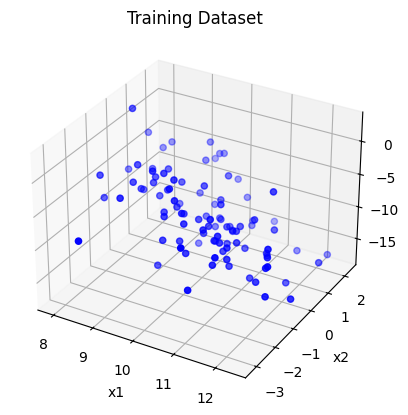

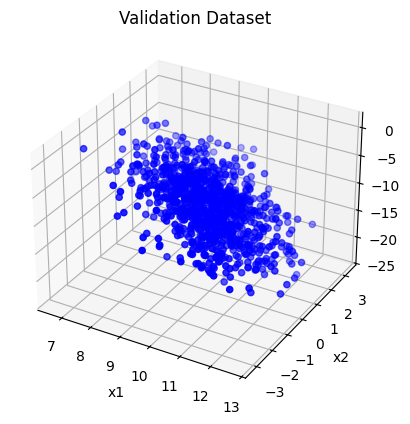

Theoretically optimal theta parameters from MLE: [-21.93929264  10.98967515  28.17156422  -1.55456147  -5.3482916
   2.96281805   0.05766102   0.24707052  -0.30134787   0.15459907]
Average-squared error for the ML estimator on validation set: 6.8287
Average-squared error for the MAP estimator with gamma = 0.0001: 6.8303
Average-squared error for the MAP estimator with gamma = 10000.0: 6.4066


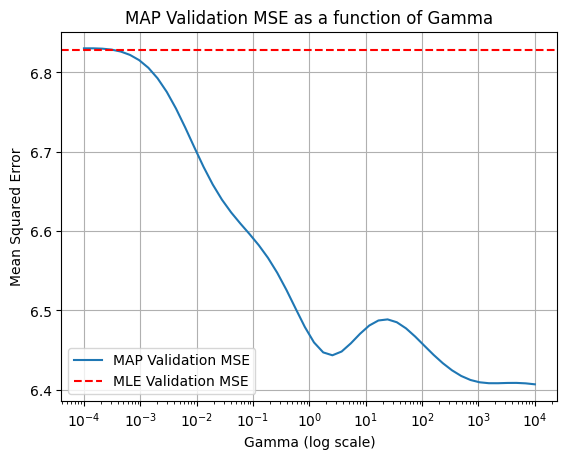

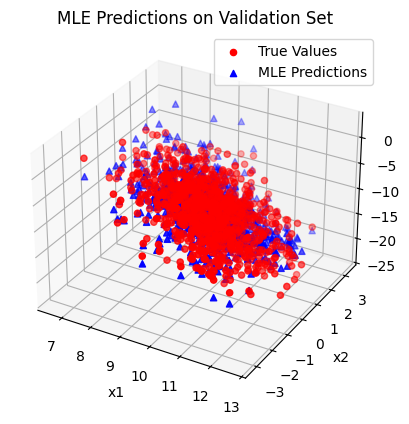

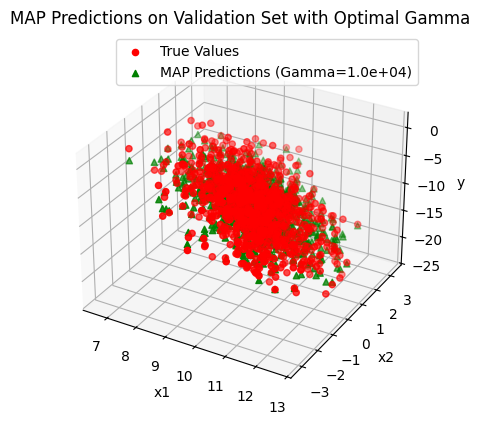

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Data Generation Functionality
def hw2q2():
    Ntrain = 100
    data = generateData(Ntrain)
    plot3(data[0, :], data[1, :], data[2, :], name="Training Dataset")
    xTrain = data[0:2, :]
    yTrain = data[2, :]

    Nvalidate = 1000
    data = generateData(Nvalidate)
    plot3(data[0, :], data[1, :], data[2, :], name="Validation Dataset")
    xValidate = data[0:2, :]
    yValidate = data[2, :]

    return xTrain.T, yTrain, xValidate.T, yValidate  # Transpose xTrain and xValidate to match (N,2) shape

def generateData(N):
    gmmParameters = {
        'priors': [0.3, 0.4, 0.3],
        'meanVectors': np.array([[-10, 0, 10], [0, 0, 0], [10, 0, -10]]),
        'covMatrices': np.zeros((3, 3, 3))
    }
    gmmParameters['covMatrices'][:, :, 0] = np.array([[1, 0, -3], [0, 1, 0],
[-3, 0, 15]])
    gmmParameters['covMatrices'][:, :, 1] = np.array([[8, 0, 0], [0, .5, 0],
[0, 0, .5]])
    gmmParameters['covMatrices'][:, :, 2] = np.array([[1, 0, -3], [0, 1, 0],
[-3, 0, 15]])

    x, labels = generateDataFromGMM(N, gmmParameters)
    return x

def generateDataFromGMM(N, gmmParameters):
    priors = gmmParameters['priors']
    meanVectors = gmmParameters['meanVectors']
    covMatrices = gmmParameters['covMatrices']
    n = meanVectors.shape[0]
    C = len(priors)
    x = np.zeros((n, N))
    labels = np.zeros(N)

    u = np.random.random(N)
    thresholds = np.cumsum(priors)
    for l in range(C):
        indl = u < thresholds[l]
        Nl = np.sum(indl)
        labels[indl] = l + 1
        x[:, indl] = np.random.multivariate_normal(meanVectors[:, l],
covMatrices[:, :, l], Nl).T
    return x, labels

def plot3(a, b, c, mark="o", col="b", name="Dataset"):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(a, b, c, marker=mark, color=col)
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.set_zlabel("y")
    ax.set_title(name)
    plt.show()

# Polynomial Feature Transformation for Cubic Model
def cubic_features(x):
    x1, x2 = x[:, 0], x[:, 1]
    return np.column_stack([
        np.ones(x1.shape), x1, x2, x1**2, x1 * x2, x2**2,
        x1**3, x1**2 * x2, x1 * x2**2, x2**3
    ])

# Maximum Likelihood Estimation (MLE) and MAP
def compute_mle(X, y):
    pseudo_inverse = np.linalg.pinv(X.T @ X) @ X.T
    return pseudo_inverse @ y

def compute_map(X, y, gamma):
    regularizer = gamma * np.eye(X.shape[1])
    return np.linalg.inv(X.T @ X + regularizer) @ X.T @ y

# Mean Squared Error Calculation
def mean_squared_error(predictions, targets):
    return np.mean((predictions - targets) ** 2)

# Main Execution
x_train, y_train, x_validate, y_validate = hw2q2()

# Transform features for cubic model
X_train = cubic_features(x_train)
X_validate = cubic_features(x_validate)

# MLE Solution
w_mle = compute_mle(X_train, y_train)
y_pred_mle_validate = X_validate @ w_mle
mse_mle_validate = mean_squared_error(y_pred_mle_validate, y_validate)
print("Theoretically optimal theta parameters from MLE:", w_mle)
print(f"Average-squared error for the ML estimator on validation set: {mse_mle_validate:.4f}")

# MAP Solution with specific gamma values
gamma_low = 1e-4
gamma_high = 1e4

# MAP with low gamma
w_map_low = compute_map(X_train, y_train, gamma_low)
y_pred_map_validate_low = X_validate @ w_map_low
mse_map_validate_low = mean_squared_error(y_pred_map_validate_low, y_validate)
print(f"Average-squared error for the MAP estimator with gamma = {gamma_low}: {mse_map_validate_low:.4f}")

# MAP with high gamma
w_map_high = compute_map(X_train, y_train, gamma_high)
y_pred_map_validate_high = X_validate @ w_map_high
mse_map_validate_high = mean_squared_error(y_pred_map_validate_high,
y_validate)
print(f"Average-squared error for the MAP estimator with gamma = {gamma_high}: {mse_map_validate_high:.4f}")

# MAP Solution with varying gamma for full analysis
gamma_values = np.geomspace(1e-4, 1e4, 50)
mse_map_validate = []

for gamma in gamma_values:
    w_map = compute_map(X_train, y_train, gamma)
    y_pred_map_validate = X_validate @ w_map
    mse_map_validate.append(mean_squared_error(y_pred_map_validate, y_validate))

# Plot MSE for MAP across gamma values
plt.figure()
plt.plot(gamma_values, mse_map_validate, label="MAP Validation MSE")
plt.axhline(mse_mle_validate, color='red', linestyle='--', label="MLE Validation MSE")
plt.xscale("log")
plt.xlabel("Gamma (log scale)")
plt.ylabel("Mean Squared Error")
plt.title("MAP Validation MSE as a function of Gamma")
plt.legend()
plt.grid(True)
plt.show()

# 3D Plot for MLE on Validation Set
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_validate[:, 0], x_validate[:, 1], y_validate, color='red',
marker='o', label="True Values")
ax.scatter(x_validate[:, 0], x_validate[:, 1], y_pred_mle_validate, color='blue', marker='^', label="MLE Predictions")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("y")
plt.title("MLE Predictions on Validation Set")
ax.legend()
plt.show()

# 3D Plot for MAP with optimal gamma on Validation Set
optimal_gamma = gamma_values[np.argmin(mse_map_validate)]
w_map_optimal = compute_map(X_train, y_train, optimal_gamma)
y_pred_map_validate_optimal = X_validate @ w_map_optimal

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_validate[:, 0], x_validate[:, 1], y_validate, color='red',
marker='o', label="True Values")
ax.scatter(x_validate[:, 0], x_validate[:, 1], y_pred_map_validate_optimal, color='green', marker='^', label=f"MAP Predictions (Gamma={optimal_gamma:.1e})")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("y")
plt.title("MAP Predictions on Validation Set with Optimal Gamma")
ax.legend()
plt.show()

## **Question 3**


Localization with K=1 landmarks
MAP Estimate for position: [-2.18988306e-01 -3.27606785e-09]
True Position: [-0.11908261 -0.53573836]


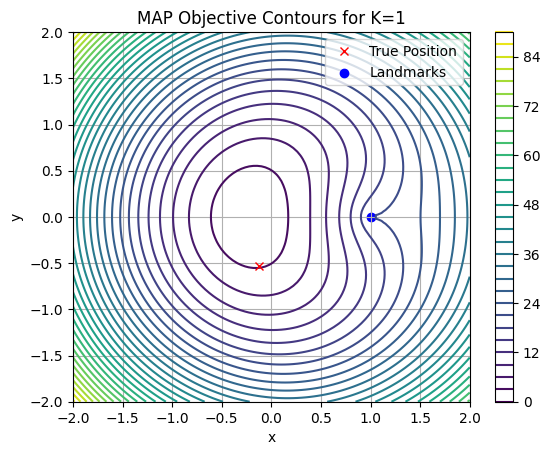


Localization with K=2 landmarks
MAP Estimate for position: [-9.35106588e-02 -4.64744483e-09]
True Position: [-0.11908261 -0.53573836]


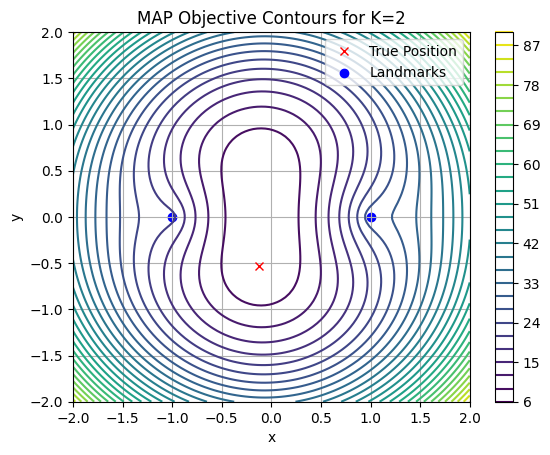


Localization with K=3 landmarks
MAP Estimate for position: [ 0.03007166 -0.36305039]
True Position: [-0.11908261 -0.53573836]


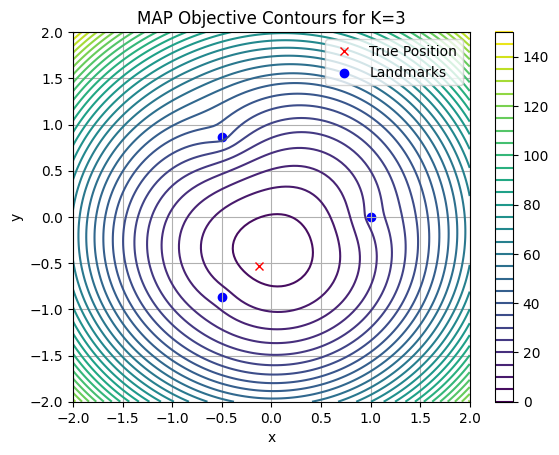


Localization with K=4 landmarks
MAP Estimate for position: [-0.04736467 -0.23266101]
True Position: [-0.11908261 -0.53573836]


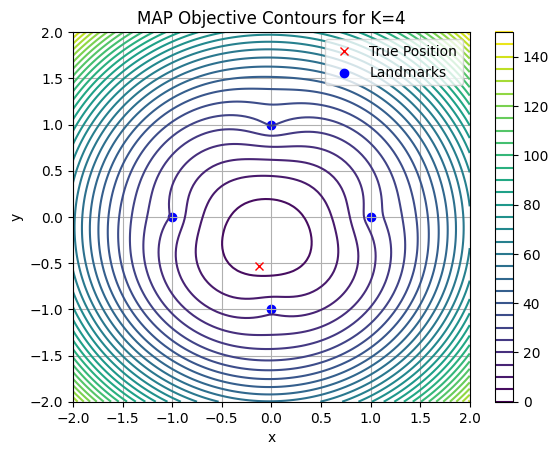

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Set parameters
sigma = 0.3
sigma_x = 0.25
sigma_y = 0.25

# Define true vehicle position within unit circle centered at origin
np.random.seed(0)
r_true = np.random.uniform(0, 1)
theta_true = np.random.uniform(0, 2 * np.pi)
x_true = r_true * np.cos(theta_true)
y_true = r_true * np.sin(theta_true)
true_position = np.array([x_true, y_true])

# Function to place landmarks evenly on a unit circle
def generate_landmarks(K):
    angles = np.linspace(0, 2 * np.pi, K, endpoint=False)
    return np.column_stack((np.cos(angles), np.sin(angles)))

# Generate noisy range measurements
def generate_measurements(landmarks, true_position, sigma):
    ranges = np.linalg.norm(landmarks - true_position, axis=1)
    noisy_ranges = ranges + np.random.normal(0, sigma, size=ranges.shape)
    noisy_ranges = np.maximum(noisy_ranges, 0)
    return noisy_ranges

# Define the MAP objective function to minimize (negative log posterior)
def map_objective(position, landmarks, ranges, sigma, sigma_x, sigma_y):
    x, y = position
    distances = np.linalg.norm(landmarks - position, axis=1)
    likelihood_term = np.sum((ranges - distances) ** 2) / (2 * sigma ** 2)
    prior_term = (x ** 2) / (2 * sigma_x ** 2) + (y ** 2) / (2 * sigma_y ** 2)
    return likelihood_term + prior_term

# Plotting function for contours
def plot_contours(K, landmarks, ranges, sigma, sigma_x, sigma_y,
true_position):
    x_grid = np.linspace(-2, 2, 100)
    y_grid = np.linspace(-2, 2, 100)
    X, Y = np.meshgrid(x_grid, y_grid)

    Z = np.array([ map_objective((x, y), landmarks, ranges, sigma, sigma_x, sigma_y) for x, y in zip(X.ravel(), Y.ravel()) ]).reshape(X.shape)

    plt.figure()
    cp = plt.contour(X, Y, Z, levels=30, cmap='viridis')
    plt.colorbar(cp)
    plt.plot(true_position[0], true_position[1], 'rx', label="True Position")
    plt.scatter(landmarks[:, 0], landmarks[:, 1], marker='o', color='blue',
label="Landmarks")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"MAP Objective Contours for K={K}")
    plt.legend()
    plt.grid(True)
    plt.show()

# Main function to perform localization for different values of K
def localization_experiment():
    for K in range(1, 5):
        print(f"\nLocalization with K={K} landmarks")

        # Generate K landmarks
        landmarks = generate_landmarks(K)

        # Generate range measurements with noise
        ranges = generate_measurements(landmarks, true_position, sigma)

        # Initial guess for optimization
        initial_guess = np.array([0, 0])

        # Find MAP estimate by minimizing the objective
        result = minimize(
            map_objective,
            initial_guess,
            args=(landmarks, ranges, sigma, sigma_x, sigma_y),
            method='L-BFGS-B' )

        map_estimate = result.x
        print(f"MAP Estimate for position: {map_estimate}")
        print(f"True Position: {true_position}")

        plot_contours(K, landmarks, ranges, sigma, sigma_x, sigma_y,
true_position)
localization_experiment()